## Gemeindedatenbank-API via Kafka Producer/Consumer

Auf der Seite https://gedaba.agrarforschung.at/home sind die wichtigsten landwirtschaftlich relevanten Strukturdaten wie Flächen, Tiere, Betriebe, Einwohner, etc. sowie die Nächtigungen enthalten.

Damit umfasst die Datenbank knapp 900 Merkmale mit derzeit ca. 8,5 Mio. Datensätzen. 
Die Daten liegen grundsätzlich ab dem Jahr 2000 auf Gemeindeebene vor, nicht zuordenbare Daten wurden der Hauptstadt der nächst größeren geografischen Einheit zugeordnet. 

Die Seite stellt eine api zur Verfügung, die man über https://gedaba.agrarforschung.at/api/application/query ansprechen kann.

Zunächst werden die nötigen Libraries geladen.

In [1]:
# load important libraries
from time import sleep
from json import dumps
import requests
import json

from kafka import KafkaProducer
from kafka import KafkaConsumer

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob

# kafka-host hat Port kafka:9092, weil er gemeinsam mit Spark in einem Container läuft 
kafka_host = 'kafka:9092'

Nun wird der Kafka Producer erzeugt.

In [ ]:
# create producer
producer = KafkaProducer(
    bootstrap_servers=kafka_host, #Kafka server
    value_serializer=lambda v: json.dumps(v).encode('utf-8') #json serializer
    )

In [ ]:
# value as string
# bundesland in CAPITAL LETTERS
def loadGeDaBaToFile(value, bundesland):
    url = 'https://gedaba.agrarforschung.at/api/application/query'
    headers = {'Content-Type': 'application/json'}
    json_path = 'Klimadaten/data/agrar/data_' +  bundesland + '_' + value + '.json'
    #gedaba_topic = 'gedaba_' + bundesland + '_' + value
    gedaba_topic = 'gedaba_' + '_' + value
    print(json_path)
    
    # Auf der Seite findet man die Info, welches Request-Objekt man mitgeben muss, damit man 
    # zB die Daten über Weizen abrufen kann, dieses wird dem request mitgegeben (payload):
    payload = {'id': 5, 'parameters': [{'name': 'mc_liste', 'value': value}]}
    r = requests.post(url, json=payload, headers=headers)
    
    # Nun wird das Json Objekt in ein Python Objekt umgespeichert, die Daten, die analysiert 
    # werden sollen, zB Burgenland werden gefiltert, danach wird wieder zurück nach JSON gespeichert.
    input_dict = r.json()['data']['data'] # json.loads(r.json())
    output_dict = [x for x in input_dict if x['bundesland'] == bundesland] # 'bundesland': 'BURGENLAND'
    output_json = json.dumps(output_dict)
    
    # Diese Daten werden nun dem Producer übergeben, da es eine große Datenmenge ist, muss in das 
    # Objekt future gespeichert werden, damit man ein timeout einstellen kann.
    future = producer.send(gedaba_topic, value = output_json)
    try:
        record_metadata = future.get(timeout=10)
    except Exception as ex:
        print('Error: ' + str(ex))
        pass
    
    # Nun wird der Consumer erzeugt.
    consumer = KafkaConsumer(
     bootstrap_servers=kafka_host,
     value_deserializer = lambda v: json.loads(v.decode('ascii')),
     auto_offset_reset='earliest'
    )
    
    # Der Consumer "subscribed" das Topic "gedaba", dann werden die Daten lokal gespeichert.
    consumer.subscribe(topics=gedaba_topic)
    v = next(consumer).value
    j = json.loads(v)
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(j, f)

# get ids:
# 1015, 1016. 1017 (weizen)

In [ ]:
for value in ["30", "1015", "1016", "1017"]:
    for bl in ["NIEDERÖSTERREICH"]: # , "NIEDERÖSTERREICH" BURGENLAND
        loadGeDaBaToFile(value, bl)

Nun wird eine Sparksession erzeugt und das JSON-Objekt in einen Spark-Dataframe eingelesen:

In [21]:
path = '../data/agrar/'
files = glob.glob(path + 'data_*.json')

li = []

for f in files:
    spark = SparkSession \
        .builder \
        .appName("Read Data") \
        .getOrCreate()
    spdf = spark.read.json(f)
    # Der Spark-Dataframe wird in einen Panda-Dataframe umgewandelt:
    df = spdf.toPandas()
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)
data

,bkz,bundesland,einheit,gemeindename,gkz5,jahr,mc,merkmal,politischer_bezirk,ressort,wert
0,101,BURGENLAND,ha,Eisenstadt,10101,2000,1015,Winterweichweizen,Eisenstadt(Stadt),BMLRT,205.6200
1,101,BURGENLAND,ha,Eisenstadt,10101,2001,1015,Winterweichweizen,Eisenstadt(Stadt),BMLRT,221.1100
2,101,BURGENLAND,ha,Eisenstadt,10101,2002,1015,Winterweichweizen,Eisenstadt(Stadt),BMLRT,220.2600
3,101,BURGENLAND,ha,Eisenstadt,10101,2003,1015,Winterweichweizen,Eisenstadt(Stadt),BMLRT,179.6500
4,101,BURGENLAND,ha,Eisenstadt,10101,2004,1015,Winterweichweizen,Eisenstadt(Stadt),BMLRT,251.0900
...,...,...,...,...,...,...,...,...,...,...,...
5903,109,BURGENLAND,ha,Badersdorf,10931,2008,30,Weingärten,Oberwart,BMLRT,8.4000
5904,109,BURGENLAND,ha,Badersdorf,10931,2009,30,Weingärten,Oberwart,BMLRT,9.9600
5905,109,BURGENLAND,ha,Badersdorf,10931,2010,30,Weingärten,Oberwart,BMLRT,10.0900
5906,109,BURGENLAND,ha,Badersdorf,10931,2020,30,Weingärten,Oberwart,BMLRT,17.0815


In [22]:
# replace all weizen* labels with weizen
print(data['merkmal'].unique())
# Winterweichweizen', 'Sommerweichweizen', 'Hartweizen (Durum)'
data.loc[data["merkmal"] == "Winterweichweizen" , "merkmal"] = "Weizen"
data.loc[data["merkmal"] == "Sommerweichweizen" , "merkmal"] = "Weizen"
data.loc[data["merkmal"] == "Hartweizen (Durum)", "merkmal"] = "Weizen"
print(data['merkmal'].unique())


['Winterweichweizen' 'Sommerweichweizen' 'Hartweizen (Durum)' 'Weingärten']
['Weizen' 'Weingärten']


In [23]:
bez = data.groupby(by = ['gkz5', 'gemeindename', 'jahr', 'merkmal'], as_index=False)['wert'].sum()
bez

,gkz5,gemeindename,jahr,merkmal,wert
0,10101,Eisenstadt,2000,Weingärten,487.3300
1,10101,Eisenstadt,2000,Weizen,235.3100
2,10101,Eisenstadt,2001,Weingärten,474.8400
3,10101,Eisenstadt,2001,Weizen,246.5100
4,10101,Eisenstadt,2002,Weingärten,507.8100
...,...,...,...,...,...
5170,10932,Schandorf,2017,Weizen,239.0956
5171,10932,Schandorf,2018,Weizen,251.5013
5172,10932,Schandorf,2019,Weizen,265.2605
5173,10932,Schandorf,2020,Weizen,238.5536


Visualisierung des gruppierten Datensatzes:

<AxesSubplot:xlabel='jahr', ylabel='wert'>

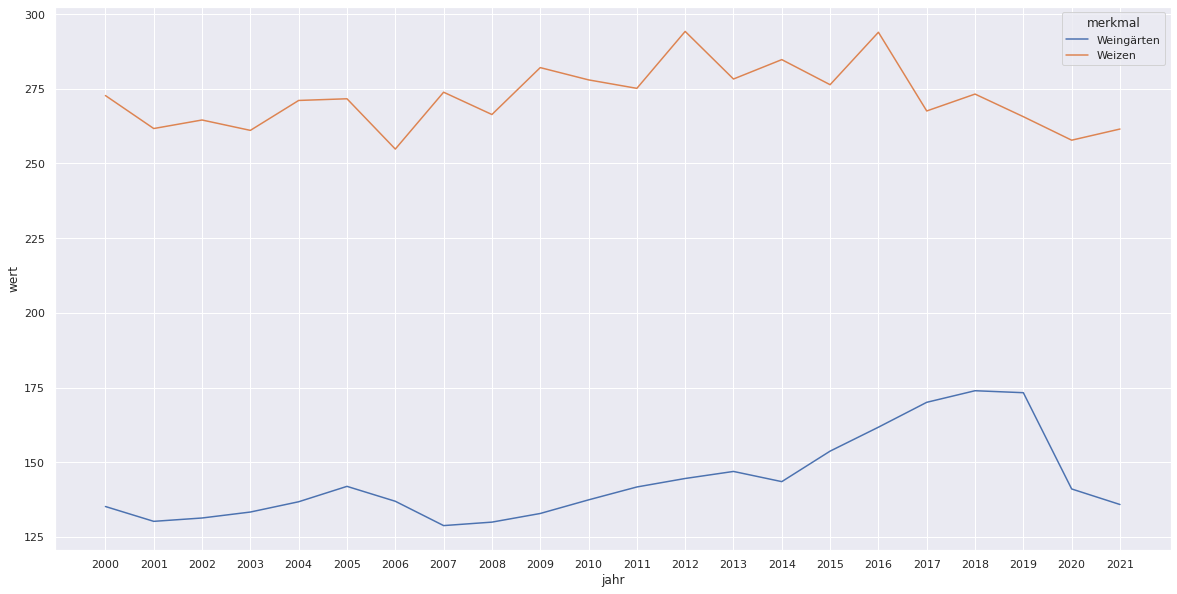

In [16]:
#fig, axes = plt.subplots(figsize=(20,10))
sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(data=bez, x="jahr", y="wert", hue="merkmal", ci=None)

#sns.lineplot(data=df, x="jahr", y="wert", hue="politischer_bezirk", ci=None)
#ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

### save to hdf5

In [24]:
bez.to_hdf('../data/agrar/burgenland.h5', key='all', mode='w')

# Niederösterreich von XLSX

In [7]:
path = '../data/agrar/'
files = glob.glob(path + 'gedaba_*.csv')

li = []

for f in files:
    print('process file ' + f)
    spark = SparkSession \
        .builder \
        .appName("Read Data") \
        .getOrCreate()
    spdf = spark.read.option("delimiter", ";").option("header", "true").option("header", "true").csv(f)
    # nur NIEDERÖSTERREICH
    spdf = spdf.filter(col("bundesland") == "NIEDERÖSTERREICH")
    spdf = spdf.withColumn('gkz5', regexp_replace('gkz5', ',', '.'))
    spdf = spdf.withColumn('gkz5', spdf['gkz5'].cast("float"))

    spdf = spdf.withColumn('wert', regexp_replace('wert', ',', '.'))
    spdf = spdf.withColumn('wert', spdf['wert'].cast("float"))
    
    spdf = spdf.withColumn('jahr', regexp_replace('jahr', ',', '.'))
    spdf = spdf.withColumn('jahr', spdf['jahr'].cast("float"))
    # Der Spark-Dataframe wird in einen Panda-Dataframe umgewandelt:
    df = spdf.toPandas()
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)
data

process file ../data/agrar/gedaba_1015.csv
process file ../data/agrar/gedaba_1016.csv
process file ../data/agrar/gedaba_1017.csv
process file ../data/agrar/gedaba_30.csv


,gkz5,gemeindename,bkz,politischer_bezirk,bundesland,mc,merkmal,einheit,ressort,jahr,wert
0,30101.0,Krems an der Donau,"301,00",Krems an der Donau (Stadt),NIEDERÖSTERREICH,"1015,00",Winterweichweizen,ha,BMLRT,2000.0,82.639999
1,30101.0,Krems an der Donau,"301,00",Krems an der Donau (Stadt),NIEDERÖSTERREICH,"1015,00",Winterweichweizen,ha,BMLRT,2001.0,80.739998
2,30101.0,Krems an der Donau,"301,00",Krems an der Donau (Stadt),NIEDERÖSTERREICH,"1015,00",Winterweichweizen,ha,BMLRT,2002.0,70.199997
3,30101.0,Krems an der Donau,"301,00",Krems an der Donau (Stadt),NIEDERÖSTERREICH,"1015,00",Winterweichweizen,ha,BMLRT,2003.0,60.250000
4,30101.0,Krems an der Donau,"301,00",Krems an der Donau (Stadt),NIEDERÖSTERREICH,"1015,00",Winterweichweizen,ha,BMLRT,2004.0,55.480000
...,...,...,...,...,...,...,...,...,...,...,...
17282,32337.0,Wöllersdorf-Steinabrückl,"323,00",Wiener Neustadt (Land),NIEDERÖSTERREICH,"30,00",Weingärten,ha,BMLRT,2001.0,4.320000
17283,32337.0,Wöllersdorf-Steinabrückl,"323,00",Wiener Neustadt (Land),NIEDERÖSTERREICH,"30,00",Weingärten,ha,BMLRT,2002.0,4.320000
17284,32337.0,Wöllersdorf-Steinabrückl,"323,00",Wiener Neustadt (Land),NIEDERÖSTERREICH,"30,00",Weingärten,ha,BMLRT,2003.0,4.320000
17285,32337.0,Wöllersdorf-Steinabrückl,"323,00",Wiener Neustadt (Land),NIEDERÖSTERREICH,"30,00",Weingärten,ha,BMLRT,2004.0,4.350000


In [8]:
# replace all weizen* labels with weizen
print(data['merkmal'].unique())
# Winterweichweizen', 'Sommerweichweizen', 'Hartweizen (Durum)'
data.loc[data["merkmal"] == "Winterweichweizen" , "merkmal"] = "Weizen"
data.loc[data["merkmal"] == "Sommerweichweizen" , "merkmal"] = "Weizen"
data.loc[data["merkmal"] == "Hartweizen (Durum)", "merkmal"] = "Weizen"
print(data['merkmal'].unique())


['Winterweichweizen' 'Sommerweichweizen' 'Hartweizen (Durum)' 'Weingärten']
['Weizen' 'Weingärten']


In [9]:
bez = data.groupby(by = ['gkz5', 'gemeindename', 'jahr', 'merkmal'], as_index=False)['wert'].sum()
bez

,gkz5,gemeindename,jahr,merkmal,wert
0,30101.0,Krems an der Donau,2000.0,Weingärten,508.149994
1,30101.0,Krems an der Donau,2000.0,Weizen,82.639999
2,30101.0,Krems an der Donau,2001.0,Weingärten,477.890015
3,30101.0,Krems an der Donau,2001.0,Weizen,80.739998
4,30101.0,Krems an der Donau,2002.0,Weingärten,533.500000
...,...,...,...,...,...
14154,32530.0,Zwettl-Niederösterreich,2017.0,Weizen,431.599976
14155,32530.0,Zwettl-Niederösterreich,2018.0,Weizen,458.019989
14156,32530.0,Zwettl-Niederösterreich,2019.0,Weizen,449.880005
14157,32530.0,Zwettl-Niederösterreich,2020.0,Weizen,441.269989


In [20]:
bez = data.groupby(by = ['gkz5', 'gemeindename', 'jahr', 'merkmal'], as_index=False)['wert'].sum()
bez

,gkz5,gemeindename,jahr,merkmal,wert
0,30101.0,Krems an der Donau,2000.0,Weingärten,508.149994
1,30101.0,Krems an der Donau,2000.0,Weizen,82.639999
2,30101.0,Krems an der Donau,2001.0,Weingärten,477.890015
3,30101.0,Krems an der Donau,2001.0,Weizen,80.739998
4,30101.0,Krems an der Donau,2002.0,Weingärten,533.500000
...,...,...,...,...,...
14154,32530.0,Zwettl-Niederösterreich,2017.0,Weizen,431.599976
14155,32530.0,Zwettl-Niederösterreich,2018.0,Weizen,458.019989
14156,32530.0,Zwettl-Niederösterreich,2019.0,Weizen,449.880005
14157,32530.0,Zwettl-Niederösterreich,2020.0,Weizen,441.269989


In [21]:
bez.to_hdf('../data/agrar/noe.h5', key='all', mode='w')